**In this notebook we will be developing different models and evaluate how they work on our Football Players Price prediction data.**
****
Let's import required modules.

In [1]:
# Importing modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle                                          
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display
import warnings

In [2]:
# Disable displaying warnings
warnings.filterwarnings("ignore")

****
Let's define some functions which we will use later.

In [3]:
# Combining columns using feature engineering
def combine(col_key, df):
    df[col_key] = (df[col_key+"_champ"]*0.15) + (df[col_key+"_cup"]*0.75) + (df[col_key+"_continent"])
    df[col_key] = df[col_key].astype(int)
    df.drop([col_key+"_cup", col_key+"_champ", col_key+"_continent"], axis=1, inplace=True)
    

# Max Normalisation
def normalise(cols, df):
    for col_key in cols:
        df[col_key] = df[col_key] / np.max(df[col_key])
        
        
# RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))
        

# Creating DNN    
def create_DNN(drop=0.2, act="relu", optimizer="adam"):
    model = Sequential()
    model.add(Dense(30, input_shape=(len(X_train.iloc[0,:]),), activation=act))
    model.add(Dropout(drop))
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(drop))
    model.add(Dense(20, activation=act))
    model.add(Dropout(drop))
    model.add(Dense(15, activation="relu"))
    model.add(Dropout(drop))
    model.add(Dense(15, activation=act))
    model.add(Dropout(drop))
    model.add(Dense(5, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

****
Let's load our data.

In [4]:
# Loading data
data = pd.read_csv("../input/football-players-price-dataset/dataset_football_cleaned.csv")

****
Let's start preprocessing our data.

In [5]:
# Converting into correct dtype
data[["name", "first_name", "nation", "league", "team", "position"]] = data[["name", "first_name", "nation", "league", "team", "position"]].astype("category")

# Mean Imputation
data["end_contract"].fillna(int(np.mean(data["end_contract"])), inplace=True)

# Dropping unimportant features which can't be used for feature engineering
data.drop(["name", "first_name"], axis=1, inplace=True)

# Dropping columns containing no values
data.drop(["clean_sheet_champ", "conceded_goal_cup", "clean_sheet_cup", "conceded_goal_continent", "clean_sheet_continent"], axis=1, inplace=True)

# Dropping unimportant feature which is useless for feature engineering
data.drop(["conceded_goal_champ"], axis=1, inplace=True)

# Dropping unimportant feature which is useless for feature engineering
data.drop(["age"], axis=1, inplace=True)

In [6]:
# Creating new features from existing features while preserving corrolations and reducing dimensions using feature engineering

combine("goal", data)
combine("assist", data)
combine("sub_out", data)
combine("sub_on", data)
combine("yellow_card", data)
combine("penalty_goal", data)
combine("second_yellow_card", data)
combine("red_card", data)
combine("own_goal", data)

In [7]:
# Instantiating mean encoder for categorical features
te = TargetEncoder(cols=["nation", "league", "team", "position"])

# Fitting encoder to data
te.fit(data[["nation", "league", "team", "position"]], data["price"])

# Mean encoding data 
data[["nation", "league", "team", "position"]] = te.transform(data[["nation", "league", "team", "position"]])

In [8]:
# Max Normalising numerical features
normalise(["nation", "league", "team", "goals_selection", "selections_nation", "position", "end_contract", "goal", "assist",  \
            "sub_out", "sub_on", "yellow_card", "penalty_goal", "second_yellow_card", "red_card", "own_goal"], df=data)

# Normalising target variable (It helps in efficient training of some algorithms)
max_price = np.max(data["price"])
data["price_normalised"] = data["price"]/max_price 

# displaying correlations after processing our data
display(pd.DataFrame(data.corr()["price_normalised"]).sort_values(["price_normalised"], ascending=False))

,price_normalised
price_normalised,1.000000
price,1.000000
team,0.729313
goal,0.437034
assist,0.430180
league,0.379942
goals_selection,0.375067
end_contract,0.310738
sub_out,0.294645
selections_nation,0.288971


In [9]:
# Dropping unimportant features
data.drop(["position", "second_yellow_card", "red_card", "own_goal", "penalty_goal"], axis=1, inplace=True)

****
Let's Export the data we processed.

In [10]:
# Creating csv file of processed data
data.to_csv("preprocessed_data.csv")

****
Splitting data into training and validation sets.

In [11]:
# Train test splitting
X = data.loc[:, (data.columns!="price") & (data.columns!="price_normalised")]
y = data["price_normalised"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

****
Let's create different models.

In [12]:
# Evaluating with Linear Regression algorithm
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [13]:
# Evaluating with Random Forest Regression algorithm
rfr = RandomForestRegressor(n_estimators=600, max_depth=40, min_samples_leaf=2, min_samples_split=15)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)

In [14]:
# Evaluating with gradient boosting algorithm
xgbr = XGBRegressor(objective="reg:linear", random_state=22)
xgbr.fit(X_train, y_train)
xgbr_pred = xgbr.predict(X_test)

[15:04:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


In [15]:
# Evaluating with elastic net regression algorithm
enr = ElasticNet(max_iter=18, alpha=0.0001, l1_ratio = 1)
enr.fit(X_train, y_train)
enr_pred = enr.predict(X_test)

In [16]:
# Evaluating with DNN regression algorithm

# Instantiating early stopping callback
es = EarlyStopping(monitor="mean_squared_error", mode='min', verbose=2, patience=3)

# Creating DNN
dnn = create_DNN(drop=0.1, act="tanh")

# Fitting to data
dnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=20, callbacks=[es])

# Generating predictions
dnn_pred = dnn.predict(X_test)

Epoch 1/100
445/445 [==============================] - 5s 6ms/step - loss: 9.7795e-04 - val_loss: 6.4995e-04
Epoch 2/100
445/445 [==============================] - 2s 4ms/step - loss: 7.3033e-04 - val_loss: 7.2899e-04
Epoch 3/100
445/445 [==============================] - 2s 4ms/step - loss: 5.8456e-04 - val_loss: 7.6087e-04
Epoch 4/100
445/445 [==============================] - 2s 4ms/step - loss: 5.9995e-04 - val_loss: 5.6355e-04
Epoch 5/100
445/445 [==============================] - 2s 4ms/step - loss: 5.9812e-04 - val_loss: 5.8169e-04
Epoch 6/100
445/445 [==============================] - 2s 5ms/step - loss: 7.7539e-04 - val_loss: 5.9527e-04
Epoch 7/100
445/445 [==============================] - 2s 4ms/step - loss: 5.0140e-04 - val_loss: 5.6855e-04
Epoch 8/100
445/445 [==============================] - 2s 4ms/step - loss: 4.6318e-04 - val_loss: 5.4532e-04
Epoch 9/100
445/445 [==============================] - 2s 4ms/step - loss: 5.8578e-04 - val_loss: 5.0641e-04
Epoch 10/100
445/44

In [17]:
# Weighted Average Ensemble
weighted_avg_pred = (rfr_pred*0.4)+(xgbr_pred*0.3)+(dnn_pred.reshape(len(dnn_pred))*0.3)

****
Let's compute the loss on validation data.

In [18]:
# Computing losses

lr_loss = rmse(y_test*max_price, lr_pred*max_price)
rfr_loss = rmse(y_test*max_price, rfr_pred*max_price)
xgbr_loss = rmse(y_test*max_price, xgbr_pred*max_price)
enr_loss = rmse(y_test*max_price, enr_pred*max_price)
dnn_loss = rmse(y_test*max_price, dnn_pred*max_price)
weighted_avg_loss = rmse(y_test*max_price, weighted_avg_pred*max_price)

****
Let's visualise the loss of our models.

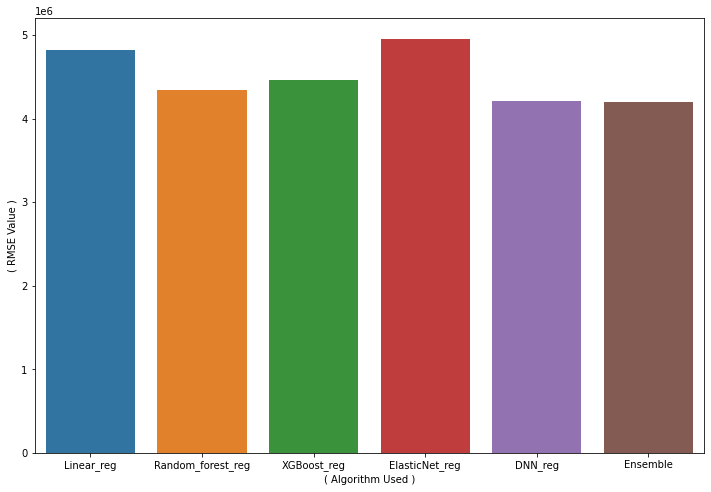

In [19]:
# Visualising comparison of our models by RMSE

x = ["Linear_reg", "Random_forest_reg", "XGBoost_reg", "ElasticNet_reg", "DNN_reg", "Ensemble"]
y = [lr_loss, rfr_loss, xgbr_loss, enr_loss, dnn_loss, weighted_avg_loss]
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x, y)
plt.xlabel("( Algorithm Used )")
plt.ylabel("( RMSE Value )")
plt.show()

****
Let's display RMSE values of our models.

In [20]:
# Displaying RMSE values of our models

print("RMSE (Linear Regression): ", lr_loss)
print("RMSE (Random Forest Regression): ", rfr_loss)
print("RMSE (Extreme Gradient Boosting Regression): ", xgbr_loss)
print("RMSE (Elastic Net Regression): ", enr_loss)
print("RMSE (DNN Regression): ", dnn_loss)
print("RMSE (Weighted Average Ensemble): ", weighted_avg_loss)

RMSE (Linear Regression):  4825278.312827822
RMSE (Random Forest Regression):  4342555.20506123
RMSE (Extreme Gradient Boosting Regression):  4467950.1921190815
RMSE (Elastic Net Regression):  4958218.347060408
RMSE (DNN Regression):  4213719.784724958
RMSE (Weighted Average Ensemble):  4203864.73569847


****
Let's save our models.

In [21]:
# Saving all our models
pickle.dump(lr, open("LinearRegressor", 'wb'))
pickle.dump(rfr, open("RandomForestRegressor", 'wb'))
pickle.dump(xgbr, open("XGBRegressor", 'wb'))
pickle.dump(enr, open("ElasticNetRegressor", 'wb'))
save_model(dnn, "DNNRegressor")

**RESULTS:**
****
* Eventhough we have processed our data well and preserved correlations so well while reducing dimensionality from 44 to 13, still loss values are huge. It is because high standard deviation in our target variable "price". So, The loss value cannot be reduced below a certain level.
* We can't use this dataset to achieve great accuracy since the price value varies from too low to too high continuosly (not outliers).
* From our evaluation, Random Forest, XGBoost, DNN Regression algorithms works better than other models in our data.
* Weighted average of predictions of the above mentioned models(Ensemble) reduces the error further improving accuracy.
****